In [ ]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms, datasets

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
mnist_dataset = datasets.MNIST(root='data/', download=True, transform=transform, train=True)
train_set = mnist_dataset
train_set, validation_set = torch.utils.data.random_split(train_set,[50000,10000])
mnist_dataset = datasets.MNIST(root='data/', download=True, transform=transform, train=False)
test_set = mnist_dataset

In [ ]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.model(x)
    return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
classifier = Classifier()
classifier.to(device)

batch_size = 40
train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

optimizer = torch.optim.Adam(classifier.parameters())

In [ ]:
num_epochs = 20
num_iters = len(train_loader)

train_losses = np.zeros((num_epochs, num_iters), dtype=np.float32) 
validation_losses = np.zeros((num_epochs, num_iters), dtype=np.float32) 

train_acc_list = []
validation_acc_list = []

for epoch in range(num_epochs):
    train_acc = 0
    validation_acc = 0
    for it, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = classifier(X)
        train_acc += int(torch.sum(y == torch.argmax(out, dim=1)))
        loss = nn.CrossEntropyLoss()
        loss = loss(out, y)
        train_losses[epoch, it] = loss
        loss.backward()
        optimizer.step()
    
    train_acc = train_acc / len(train_set) * 100
    train_acc_list.append(train_acc)
    
    print('Training epoch number', epoch + 1, '-->   Loss :', train_losses[epoch].sum() / len(train_loader), ' | Accuracy :', train_acc)

    for it, (X, y) in enumerate(validation_loader):
        X, y = X.to(device), y.to(device)
        out = classifier(X)
        validation_acc += int(torch.sum(y == torch.argmax(out, dim=1)))
        loss = nn.CrossEntropyLoss()
        loss = loss(out, y)
        validation_losses[epoch, it] = loss
    
    validation_acc = validation_acc / len(validation_set) * 100
    validation_acc_list.append(validation_acc)
    if np.argmax(validation_acc_list) == epoch:
      torch.save(classifier, 'classifier.pth')

    print('Validation epoch number', epoch + 1, '-->   Loss :', validation_losses[epoch].sum() / len(validation_loader), ' | Accuracy :', validation_acc)

Training epoch number 1 -->   Loss : 0.3047326171875  | Accuracy : 91.14
Validation epoch number 1 -->   Loss : 0.17136062622070314  | Accuracy : 94.82000000000001
Training epoch number 2 -->   Loss : 0.12184302978515625  | Accuracy : 96.294
Validation epoch number 2 -->   Loss : 0.11807487487792968  | Accuracy : 96.41
Training epoch number 3 -->   Loss : 0.08265902099609375  | Accuracy : 97.524
Validation epoch number 3 -->   Loss : 0.09429158020019532  | Accuracy : 96.99
Training epoch number 4 -->   Loss : 0.061876739501953125  | Accuracy : 98.024
Validation epoch number 4 -->   Loss : 0.08645988464355468  | Accuracy : 97.52
Training epoch number 5 -->   Loss : 0.04892195434570312  | Accuracy : 98.438
Validation epoch number 5 -->   Loss : 0.09612693786621093  | Accuracy : 97.11999999999999
Training epoch number 6 -->   Loss : 0.03727574462890625  | Accuracy : 98.79400000000001
Validation epoch number 6 -->   Loss : 0.09517098999023438  | Accuracy : 97.32
Training epoch number 7 -->

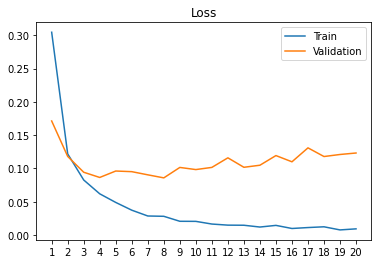

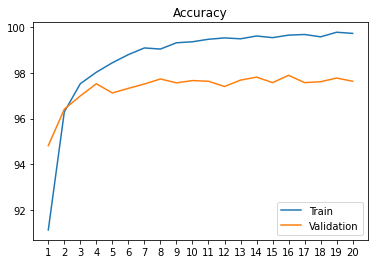

In [ ]:
x_label = np.arange(1, num_epochs + 1)
y_training_loss = np.sum(train_losses, axis=1) / len(train_loader)
y_validation_loss = np.sum(validation_losses, axis=1) / len(validation_loader)
y_training_acc = np.array(train_acc_list)
y_validation_acc = np.array(validation_acc_list)


plt.plot(x_label, y_training_loss)
plt.plot(x_label, y_validation_loss)
plt.xticks(x_label)
plt.title("Loss")
plt.legend(['Train', 'Validation'])
plt.figure()
plt.plot(x_label, y_training_acc)
plt.plot(x_label, y_validation_acc)
plt.xticks(x_label)
plt.title("Accuracy")
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
classifier = torch.load('classifier.pth')

with torch.no_grad():
    test_acc = 0
    missclassified_images = []
    counter = 0
    confusion = np.zeros((10, 10))

    for it, (X, y) in enumerate(test_loader):
        X, y = X.to(device), y.to(device)
        out = classifier(X)
        confusion[y, torch.argmax(out, dim=1)] += 1
        test_acc += int(torch.sum(y == torch.argmax(out, dim=1)))
        for i in range(len(y)):
          confusion[y[i], torch.argmax(out[i])] += 1

        miss_indices = []
        if counter < 20:
          for i in range(len(y)):
            if y[i] != torch.argmax(out[i]):
              miss_indices.append(i)
          if len(miss_indices) != 0:
            for num in miss_indices:
              counter += 1
              missclassified_images.append((X[num], int(y[num]), int(torch.argmax(out[num]))))
      
    test_acc = test_acc / len(test_set) * 100
    print('Accuracy on test set :', test_acc)

Accuracy on test set : 97.92999999999999


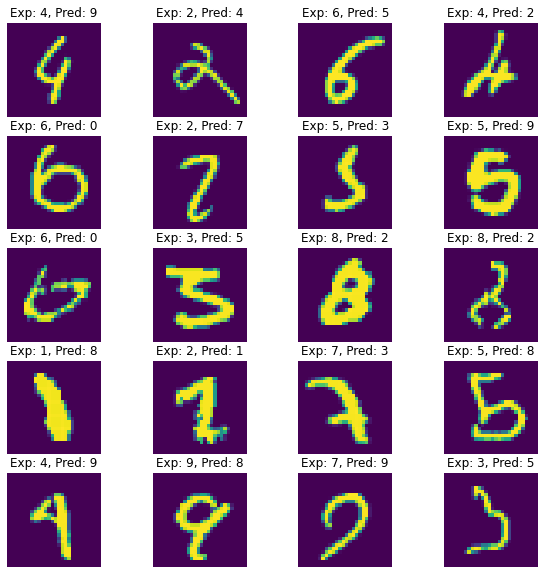

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(20):
  fig.add_subplot(5, 4, i + 1)
  plt.title('Exp: {0}, Pred: {1}'.format(missclassified_images[i][1], missclassified_images[i][2]))
  plt.axis('off')
  plt.imshow(missclassified_images[i][0].reshape(28, 28))

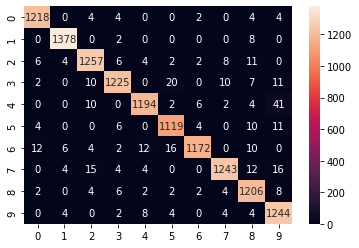

In [ ]:
import pandas as pd
seaborn.heatmap(pd.DataFrame(confusion), annot=True, fmt='g')
plt.show()